In [1]:
# for auto-reloading modules
%load_ext autoreload
%autoreload 2

In [2]:
# The following code will add the parent directory (i.e., '<Github Home>/market-modeling/') to the path Python uses to search for packages
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from models.geom_growth_models.Models import DependentCovariateModel
from metrics.Metrics import VarType
from examples import create_market, plot_train_hist, plot_covariance_matrix, plot_predictions

In [4]:
DEBUG = False
market = create_market('../data', 'popular_stocks', 'growth_timeseries', DEBUG)

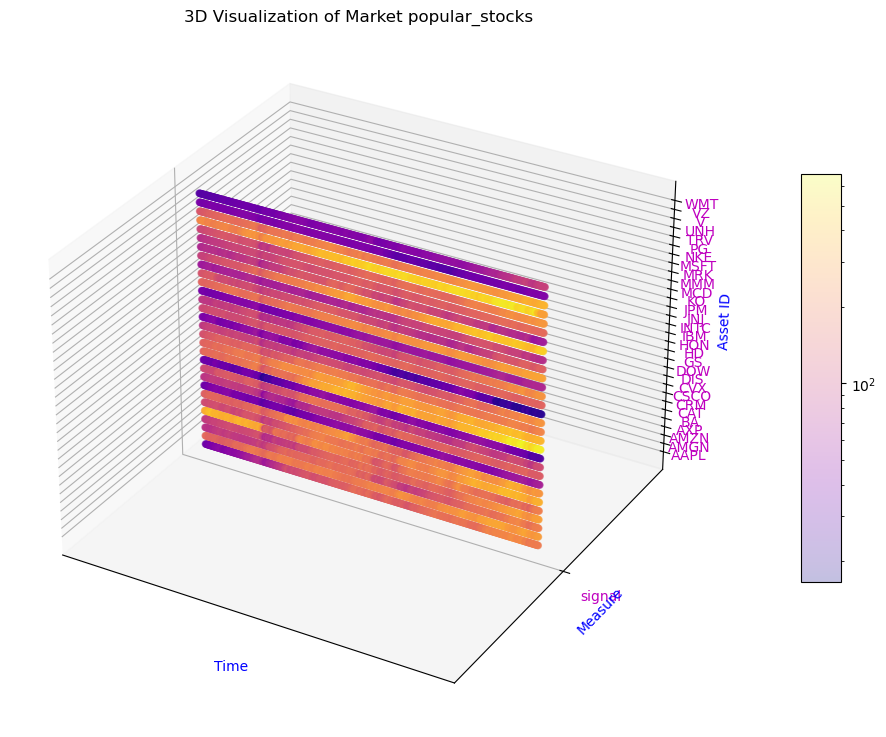

In [5]:
market.align_timeseries(True)
market.display_market()

In [6]:
from markets.DerivedVariables import DerivedVariable
from modeling_utils.py_utils import days_to_alpha, make_ewma_col_name, make_scale_diff_log_col_name, compute_next_ewma

class MasterGeomTransform(DerivedVariable):
	def __init__(self, op_name, **kwargs):
		self.signal5_name, self.signal20_name, self.signal50_name = make_ewma_col_name('signal', 5), make_ewma_col_name('signal', 20), make_ewma_col_name('signal', 50)
		self.signal5_log_diff_name, self.signal20_log_diff_name, self.signal50_log_diff_name = make_scale_diff_log_col_name(self.signal5_name), make_scale_diff_log_col_name(self.signal20_name), make_scale_diff_log_col_name(self.signal50_name)
		gen_var_types = {
			self.signal5_name: VarType.QUANTITATIVE,
			self.signal20_name: VarType.QUANTITATIVE,
			self.signal50_name: VarType.QUANTITATIVE,
			self.signal5_log_diff_name: VarType.QUANTITATIVE,
			self.signal20_log_diff_name: VarType.QUANTITATIVE,
			self.signal50_log_diff_name: VarType.QUANTITATIVE
		}
		kwargs.update({
			'alpha_weekly':days_to_alpha(5),
			'alpha_monthly':days_to_alpha(20),
			'alpha_bimonthly':days_to_alpha(50),
		})
		super().__init__(op_name, gen_var_types, **kwargs)

	def init_var(self, xr_ds, **kwargs):
		"""
		Logic to initialize variable(s) based on the other variables in a xarray Dataset.

		Args:
			xr_ds: a xarray Dataset.
			**kwargs: flexible keyword arguments to implement calculations.

		Returns: xarr_ds, with new variable(s) added
		"""
		# EWMA covars
		xr_ds[self.signal5_name] = 1. * xr_ds['signal']
		xr_ds[self.signal20_name] = 1. * xr_ds['signal']
		xr_ds[self.signal50_name] = 1. * xr_ds['signal']

		dt = (xr_ds.time - xr_ds.time.shift({'time': 1})).dt.days.values
		for i in range(1, len(dt)):
			xr_ds[self.signal5_name].data[i, :] = compute_next_ewma(xr_ds[self.signal5_name].data[i - 1, :], xr_ds['signal'].data[i, :], dt[i], self.alpha_weekly)
			xr_ds[self.signal20_name].data[i, :] = compute_next_ewma(xr_ds[self.signal20_name].data[i - 1, :], xr_ds['signal'].data[i, :], dt[i], self.alpha_monthly)
			xr_ds[self.signal50_name].data[i, :] = compute_next_ewma(xr_ds[self.signal50_name].data[i - 1, :], xr_ds['signal'].data[i, :], dt[i], self.alpha_bimonthly)

		# Time-scaled log difference covariates
		xr_ds[self.signal5_log_diff_name] = 0. * xr_ds['signal']
		xr_ds[self.signal20_log_diff_name] = 0. * xr_ds['signal']
		xr_ds[self.signal50_log_diff_name] = 0. * xr_ds['signal']

		log_base_ts = np.log(xr_ds[[self.signal5_name, self.signal20_name, self.signal50_name]].to_dataarray().to_numpy())
		log_diff_ts = (log_base_ts[:, 1:, :] - log_base_ts[:, :-1, :]) / dt[None, 1:, None]
		xr_ds[self.signal5_log_diff_name].data[1:, :] = log_diff_ts[0, :, :]
		xr_ds[self.signal20_log_diff_name].data[1:, :] = log_diff_ts[1, :, :]
		xr_ds[self.signal50_log_diff_name].data[1:, :] = log_diff_ts[2, :, :]

		return xr_ds

	def update_var(self, new_xr_ds, **kwargs):
		"""
		Given a xarray Dataset with default values in the last time step, update the values of generated variable(s).

		Args:
			new_xr_ds: a xarray Dataset.
			**kwargs: flexible keyword arguments to implement calculations.
			- dt (int, optional) - delta time to between the -2nd (last known) and -1st (first generated) timestep.

		Returns: new_xarr_ds, with new values in new_xarr_ds.isel(time=-1).sel(columns defined by self.init_var()).
		"""
		dt = kwargs.get('dt', (new_xr_ds.time - new_xr_ds.time.shift({'time': 1})).dt.days.values[-1])

		# EWMA covariates
		new_xr_ds[self.signal5_name].data[-1, :] = compute_next_ewma(new_xr_ds[self.signal5_name].data[-2, :], new_xr_ds['signal'].data[-1, :], dt, self.alpha_weekly)
		new_xr_ds[self.signal20_name].data[-1, :] = compute_next_ewma(new_xr_ds[self.signal20_name].data[-2, :], new_xr_ds['signal'].data[-1, :], dt, self.alpha_monthly)
		new_xr_ds[self.signal50_name].data[-1, :] = compute_next_ewma(new_xr_ds[self.signal50_name].data[-2, :], new_xr_ds['signal'].data[-1, :], dt, self.alpha_bimonthly)

		# Time-scaled log difference covariates
		new_xr_ds[self.signal5_log_diff_name].data[-1, :] = (np.log(new_xr_ds[self.signal5_name].data[-1, :]) - np.log(new_xr_ds[self.signal5_name].data[-2, :])) / dt
		new_xr_ds[self.signal20_log_diff_name].data[-1, :] = (np.log(new_xr_ds[self.signal20_name].data[-1, :]) - np.log(new_xr_ds[self.signal20_name].data[-2, :])) / dt
		new_xr_ds[self.signal50_log_diff_name].data[-1, :] = (np.log(new_xr_ds[self.signal50_name].data[-1, :]) - np.log(new_xr_ds[self.signal50_name].data[-2, :])) / dt

		return new_xr_ds

In [7]:
market.register_derived_var(MasterGeomTransform('master_transf'))

# One/Multi hot encode hierarchical info
market.encode_indicators(True, ',')

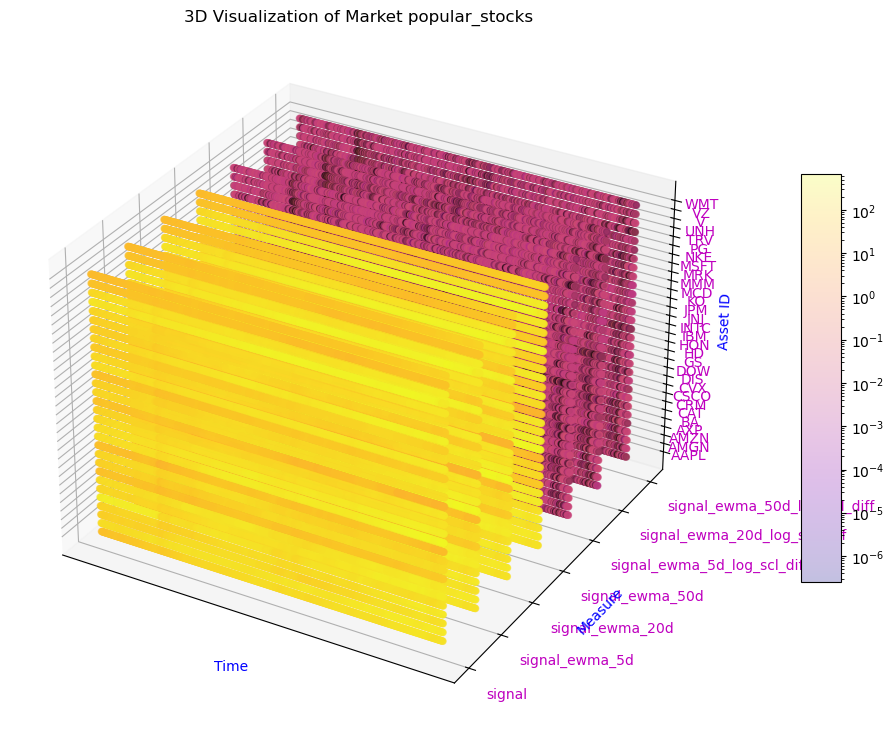

In [8]:
market.display_market(show_indicators=False)

In [9]:
mkt_var_names = market.get_quant_covars()
VARS_TO_EXCLUDE = {'signal', 'signal_ewma_5d', 'signal_ewma_20d', 'signal_ewma_50d'}
COVARS = [var for var in mkt_var_names if var not in VARS_TO_EXCLUDE]

In [10]:
dep_cov_model = DependentCovariateModel(
	covar_vars=COVARS
)

## Learn Model Parameters from Past Data

In [11]:
train_split, val_split, test_split = market.train_test_split(0.2, 0.1)

theta, train_hist = dep_cov_model.fit_global_params(
	[train_split],
	[val_split],
	train_epochs=20,
	steps_per_batch=20,
	val_freq=2,
	var_types=market.var_types,
	der_var_specs=market.derived_variables,
	lr_decay=0.1**0.5,
	l1_penalty=0.,
	save_hist=True,
	batch_size=120
)

100%|██████████| 20/20 [11:28<00:00, 34.44s/it, train_loss=3.48e+6, val_loss=8.1e+4]                               


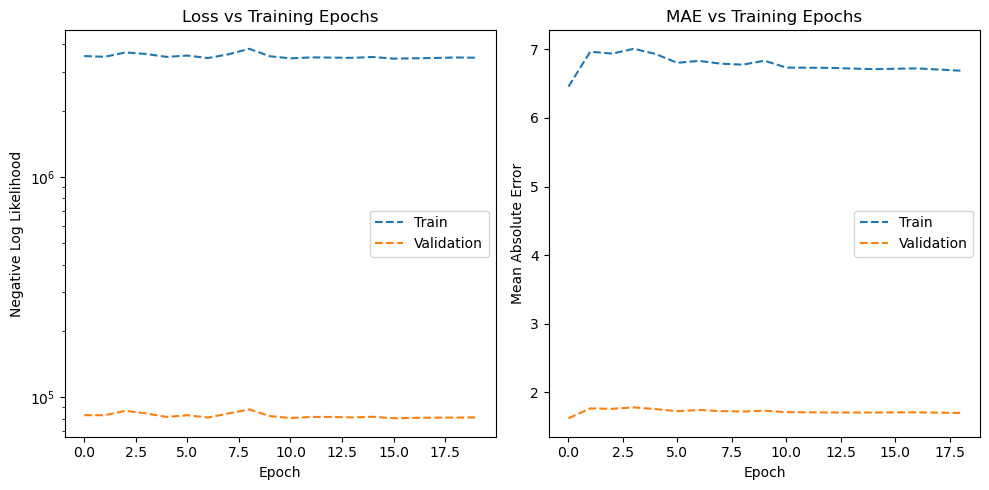

In [12]:
plot_train_hist(train_hist)

In [13]:
dep_cov_model.summarize_covariate_distributions()

,variable,coefficients
0,signal_ewma_5d_log_scl_diff,-0.041531
1,signal_ewma_20d_log_scl_diff,0.000729
2,signal_ewma_50d_log_scl_diff,0.005986
3,sector_id_technology,0.000550
4,sector_id_healthcare,0.000058
5,sector_id_consumer-cyclical,-0.000304
6,sector_id_financial-services,-0.000859
7,sector_id_industrials,-0.002122
8,sector_id_energy,-0.000038
9,sector_id_communication-services,-0.000668


## Fit Dependent+Covariate Model to the Most Recent Data

In [14]:
# fit mu, Sigma for the market, given theta
mkt_mu, mkt_Sigma = dep_cov_model.fit_local_params(
	market=None, train_ds=test_split, val_ds=None,
	train_epochs=20,	val_freq=5,
	theta=theta, covar_vars=COVARS,
	lr_decay=0.1**0.5
)

In [15]:
summ_df = pd.DataFrame({
	'ticker': market.xarray_ds['ID'].values,
	'mean': mkt_mu,
	'sigma': np.linalg.norm(mkt_Sigma, axis=0)
})

summ_df

,ticker,mean,sigma
0,AAPL,-0.000224,0.243694
1,AMGN,0.000164,0.178994
2,AMZN,0.001010,0.273386
3,AXP,0.001130,0.291651
4,BA,0.003390,0.238583
5,CAT,0.002243,0.241876
6,CRM,-0.000267,0.223300
7,CSCO,0.000681,0.184168
8,CVX,0.000140,0.183658
9,DIS,0.001962,0.219284


<Figure size 640x480 with 0 Axes>

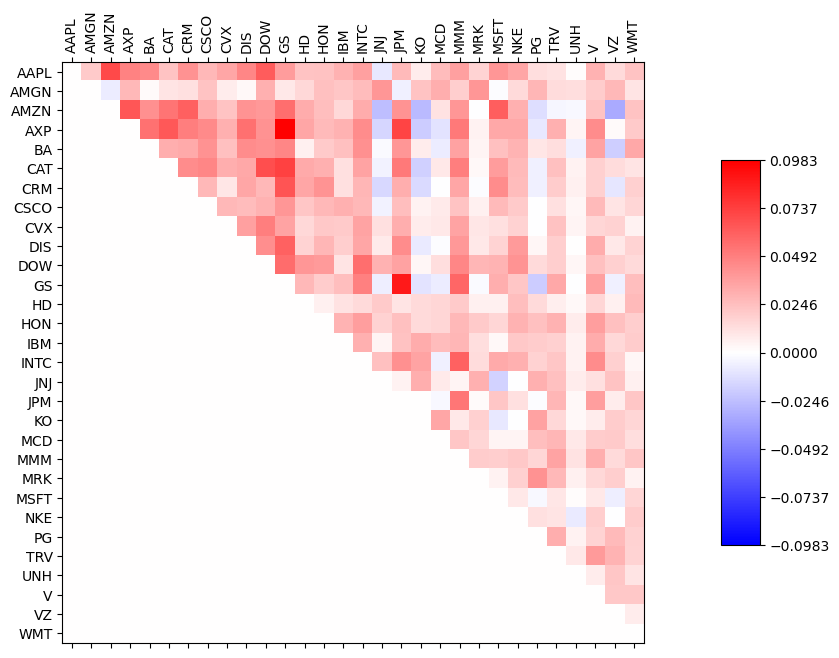

In [16]:
plot_covariance_matrix(mkt_Sigma, summ_df);

## Forecast Near-Future

In [17]:
LAST_DATE = datetime.fromtimestamp(int(market.xarray_ds['time'].max().to_numpy())//1e9)
dates_to_sim = pd.to_datetime(
  pd.Series([
	  LAST_DATE+timedelta(days=2),
	  LAST_DATE+timedelta(days=5),
	  LAST_DATE+timedelta(days=20),
	  LAST_DATE+timedelta(days=30),
  ], name='dates'),
  format='%m-%d-%Y'
)

prev_time, prev_state = market.get_market_state_before_date(min(dates_to_sim))
prev_signals = prev_state.sel(variable='signal').to_numpy()

sim_dates = pd.concat((pd.Series(prev_time, name='dates'), dates_to_sim))

In [18]:
sim_res = dep_cov_model.simulate(
	market, prev_signals, sim_dates, num_sims=20,
	mu = mkt_mu, Sigma=mkt_Sigma, theta=theta,
)

sim_counterfact = dep_cov_model.simulate(
	market, prev_signals, sim_dates, 1, add_BM=False,
	mu = mkt_mu, Sigma=mkt_Sigma, theta=theta,
)

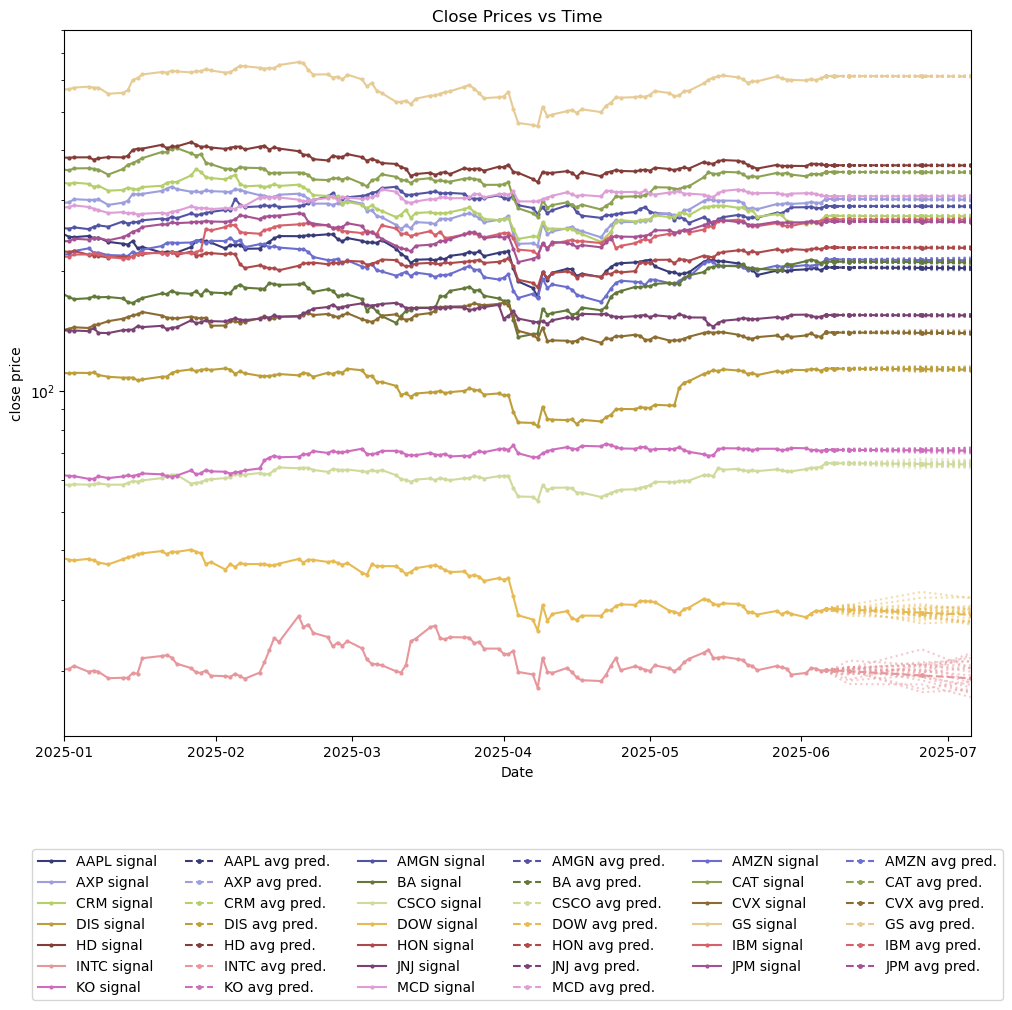

In [19]:
plot_predictions(market, sim_dates, sim_res, sim_counterfact)